# Analise de intervencoes do parlamento

## 1.Recolha e formatação de dados

Com base nos dados abertos disponibilizados no site da assembleia da republica, tive a ideia de investigar as varias [intervencoes](http://www.parlamento.pt/Cidadania/Paginas/DAIntervencoes.aspx) correspondentes a ultima legislatura. 

Começamos por importar alguns modulos importantes: 

In [1]:
from __future__ import division
import json
import nltk
import pandas as pd
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
plt.style.use('ggplot')
%matplotlib inline

Após downloadar os dados no formato json, transferimos para um dictionario chamado `interventions`.

In [2]:
with open('data/IntervencoesXIII.json') as data_file:    
    data = json.load(data_file)
    
interventions = data['ArrayOfPt_gov_ar_objectos_intervencoes_DadosPesquisaIntervencoesOut']['pt_gov_ar_objectos_intervencoes_DadosPesquisaIntervencoesOut']
print ('O dicionario tem {} intervencoes.'.format(len(interventions)))

O dicionario tem 11072 intervencoes.


Vamos fazer um print da primeira intervenção:

In [3]:
pprint(interventions[0])

{'actividadeId': '102944',
 'actividadesRelacionadas': {'id': '102944', 'tipo': 'Disc. Iniciativas'},
 'dataReuniaoPlenaria': '2016-07-20',
 'deputados': {'GP': 'PS', 'idCadastro': '1600', 'nome': 'JAMILA MADEIRA'},
 'faseSessao': 'POD',
 'idDebate': '30572',
 'iniciativas': {'pt_gov_ar_objectos_intervencoes_IniciativasOut': {'fase': 'Votação '
                                                                            'Deliberação',
                                                                    'id': '40581',
                                                                    'tipo': 'Projeto '
                                                                            'de '
                                                                            'Resolução'}},
 'legislatura': 'XIII',
 'publicacao': {'pt_gov_ar_objectos_PublicacoesOut': {'URLDiario': 'http://debates.parlamento.pt/catalogo/r3/dar/01/13/01/089/2016-07-21/115?pgs=115&org=PLC',
                                    

O formato das intervenções variam muito. Algumas têm 3 campos, outras 12. No entanto, os seguintes campos vão ser os essenciais: 

In [4]:
must_have_fields = ['deputados', 'dataReuniaoPlenaria', 'sumario']

Damos um nome as varias colunas para a nossa tabela de dados: 

In [5]:
pandas_data = [['id_debate', 'date', 'phase', 'speaker', 'political_party', 'summary_text', 'intervention_type']]

Adicionamos as intervenções a nossa "pandas dataframe".

In [6]:
# initialize counters
total = 0
retrieved = 0

# loop over list
for intervention in interventions:
    total += 1
    if all(x in intervention.keys() for x in must_have_fields):
        # define fields
        debate_id = intervention['idDebate']
        date = intervention['dataReuniaoPlenaria']
        phase = intervention['faseSessao']
        speaker = intervention['deputados']['nome']
        political_party = intervention['deputados']['GP']
        summary_text = intervention['sumario']
        intervention_type_text = intervention['tipoIntervencao']
        
        # add to pandas list
        pandas_data += [[debate_id, date, phase, speaker, political_party, summary_text, intervention_type_text]] 
        retrieved += 1

Com base neste criterio de "tem de ter estes campos", acabamos por nao perder muito..

In [7]:
print ('Intervencoes parsadas: ', total)
print ('Intervencoes que foram aceites: ', retrieved)
print ('Perdemos {}%.'.format(round(retrieved/total,2)))

Intervencoes parsadas:  11072
Intervencoes que foram aceites:  10593
Perdemos 0.96%.


Finalment podemos criar um pandas dataframe com todas as intervenções.

In [8]:
assembleia = pd.DataFrame(pandas_data[1:], columns=pandas_data[0])
assembleia = assembleia.drop_duplicates() # limpamos qualquer intervenção duplicada. 

## 2.Analise preliminar

Vamos ver o que obtemos neste dataframe: 

In [9]:
assembleia.head()

,id_debate,date,phase,speaker,political_party,summary_text,intervention_type
0,30572,2016-07-20,POD,JAMILA MADEIRA,PS,Recomenda ao Governo a elaboração de levantame...,Declaração de voto
1,30571,2016-07-20,POD,JOÃO OLIVEIRA,PCP,Regula o acesso à gestação de substituição nos...,Declaração de voto
2,30592,2016-07-20,POD,LUÍS MONTENEGRO,PSD,Cria um regime de reembolso de impostos sobre ...,Declaração de voto
3,30591,2016-07-20,POD,ANA MESQUITA,PCP,"Terceira alteração à Lei n.º 54/2005, de 15 de...",Declaração de voto
4,30590,2016-07-20,POD,ANA MESQUITA,PCP,"Altera a Lei n.º 54/2005, de 15 de novembro, q...",Declaração de voto


In [10]:
assembleia.shape
print (f'Temos {assembleia.shape[1]} colunas e {assembleia.shape[0]} linhas.')

Temos 7 colunas e 10449 linhas.


Tipos de dados? 

In [11]:
assembleia.dtypes

id_debate            object
date                 object
phase                object
speaker              object
political_party      object
summary_text         object
intervention_type    object
dtype: object

Quais os diferentes partidos? 

In [12]:
party_names = list(assembleia.political_party.unique())
print(party_names)
party_colors_rgb = [(255, 86, 231), (255, 0, 1), (255, 142, 2), (0, 136, 216), (1, 117, 0), (124, 10, 11), (0, 117, 117)]

['PS', 'PCP', 'PSD', 'CDS-PP', 'PEV', 'BE', 'PAN']


Que tipos de intervenções existem na base de dados? 

In [13]:
for tipo_de_intervencao in list(assembleia.intervention_type.unique()):
    print (tipo_de_intervencao)

Declaração de voto
Declaração politica
Defesa da honra
Explicações
Interpelação à mesa
Intervenção
Leitura
Pedido de esclarecimento
Pergunta
Réplica
Defesa da consideração
Recurso da decisão da mesa


Os anos das intervenções? 

In [14]:
assembleia.date.str.slice(0, 4).value_counts()

2017    3952
2016    3793
2018    2090
2015     614
Name: date, dtype: int64

Que tipos de intervenções acontecem mais? 

In [15]:
assembleia.intervention_type.value_counts(normalize=True)

Intervenção                   0.493444
Declaração de voto            0.208058
Pedido de esclarecimento      0.162886
Leitura                       0.047373
Pergunta                      0.039908
Interpelação à mesa           0.027754
Declaração politica           0.014547
Explicações                   0.002488
Defesa da honra               0.001818
Réplica                       0.001531
Recurso da decisão da mesa    0.000096
Defesa da consideração        0.000096
Name: intervention_type, dtype: float64

## 3.Partidos  
### 3.1.Que partidos falam mais? 

De forma a manter isto o mais simples possivel, vamos limitar os nosso resultados a intervenções do tipo `Intervenção`, que já são por si, 50%. 

Alguns tipos de declarações são limitados ao partido no governo, e existem outras coisinhas desse genero..

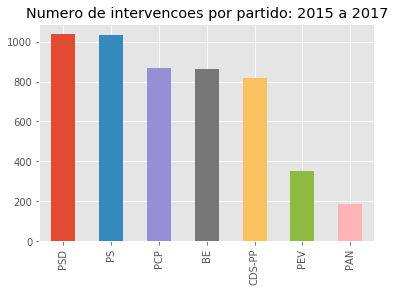

In [16]:
plt.title('Numero de intervencoes por partido: 2015 a 2017')
assembleia[(assembleia.intervention_type==u'Intervenção')].political_party.value_counts(normalize=False).plot(kind='bar')

Quem fala mais aparenta ser o PSD, seguido do PS. O BE e o PCP parecem bastante equilibrados.

Olhemos agora para o ano de 2016:

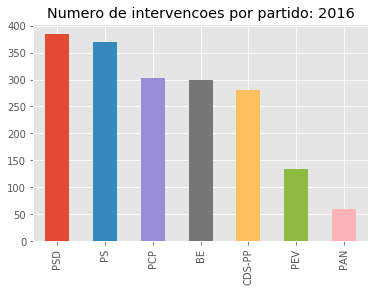

In [17]:
plt.title('Numero de intervencoes por partido: 2016')
assembleia[(assembleia.intervention_type==u'Intervenção')
           & (assembleia['date'] > '2016-01-01')
           & (assembleia['date'] < '2016-12-30')].political_party.value_counts(normalize=False).plot(kind='bar')

As tendencias aparentam ser as mesmas.

### 3.2.Que tipos de intervenções é que os partidos fazem? 

Em percentagens e valores numericos. 

In [18]:
assembleia.groupby('intervention_type').political_party.value_counts(normalize=True)

intervention_type           political_party
Declaração de voto          PS                 0.368445
                            PSD                0.333027
                            PCP                0.127415
                            CDS-PP             0.112695
                            BE                 0.043698
                            PAN                0.008280
                            PEV                0.006440
Declaração politica         PS                 0.197368
                            CDS-PP             0.184211
                            PCP                0.184211
                            PSD                0.177632
                            BE                 0.157895
                            PEV                0.098684
Defesa da consideração      PCP                1.000000
Defesa da honra             CDS-PP             0.368421
                            PSD                0.315789
                            PS                 0.210526
    

### 3.3.Intervenções ao longo do tempo

Quanto é que os partidos falam ao longo do tempo? Como exemplo, o ano de 2016 e 2017..

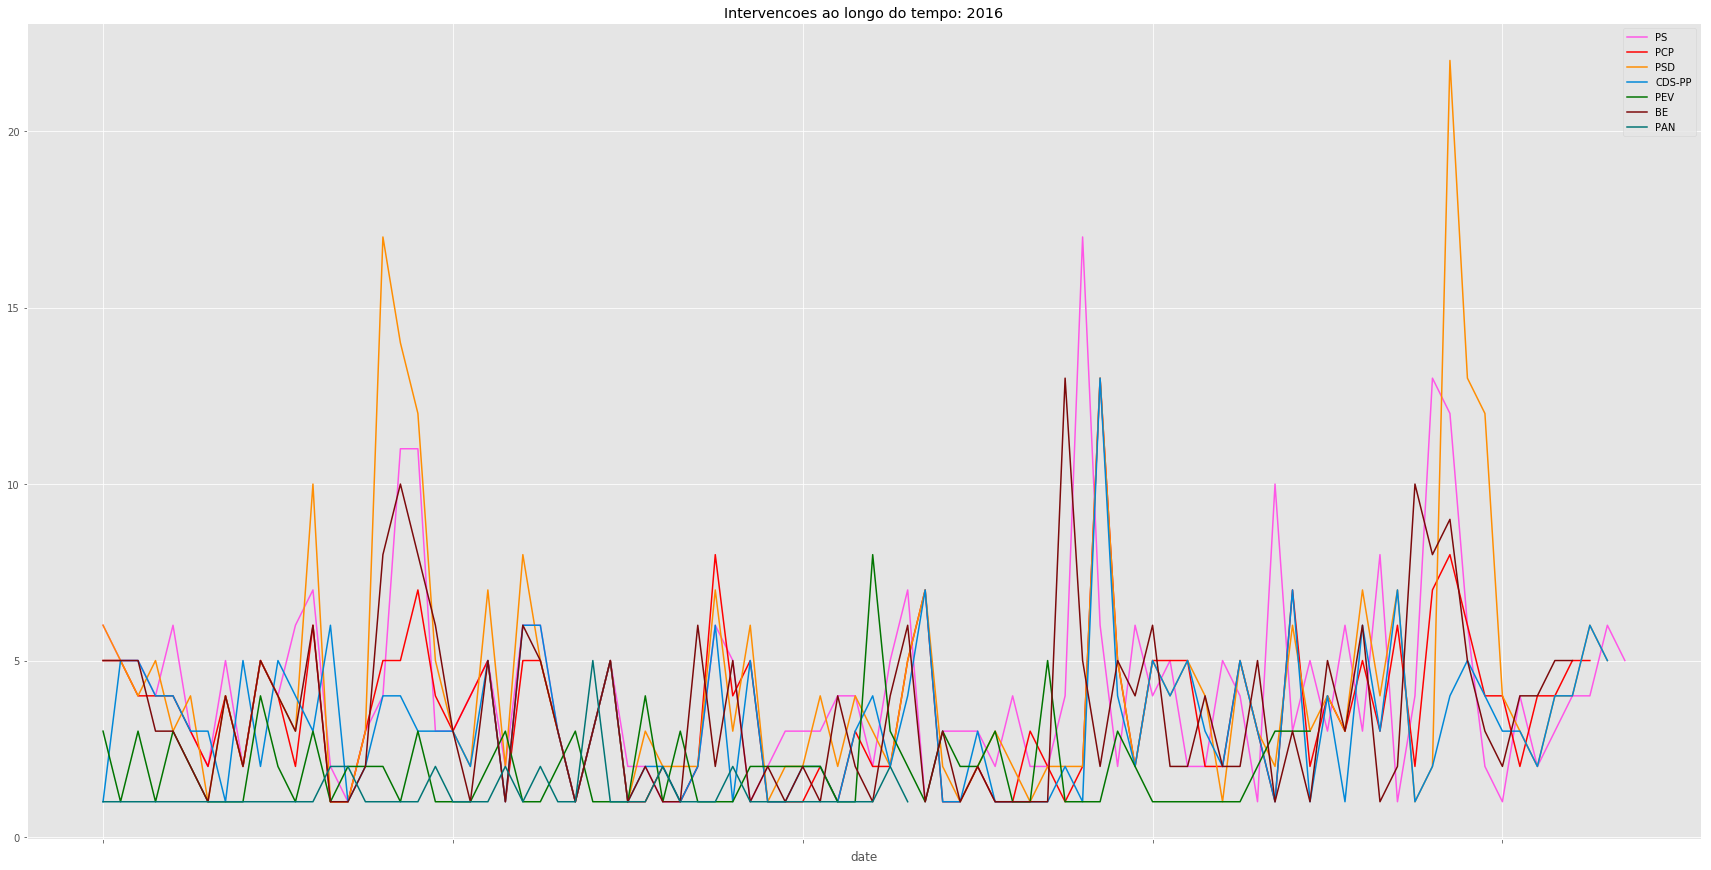

In [19]:
plt.figure(figsize=(30, 15))
plt.title('Intervencoes ao longo do tempo: 2016')
for index, partido in enumerate(party_names):
    assembleia[(assembleia.intervention_type==u'Intervenção') 
               & (assembleia.political_party==partido)
               & (assembleia['date'] > '2016-01-01')
               & (assembleia['date'] < '2017-01-01') ].groupby(assembleia.date).intervention_type.count().plot(label=partido, color=tuple(e/255 for e in party_colors_rgb[index]))
    
plt.legend()

### 3.4.Wordcloud de um partido

Criamos algumas funções que podem ajudar.

In [20]:
def tokenized_text(party):
    """
    Returns the token list of all of the party interventions
    """

    # vamos buscar dados a dataframe
    interventions_of_party = assembleia.loc[(assembleia.political_party == party) &
                   (assembleia.intervention_type == u'Intervenção')].drop_duplicates(subset='summary_text', keep="last") # tabela com intervenções
    interventions_of_party = interventions_of_party.drop_duplicates() # limpar duplicate rows se existirem ainda

    # agregamos dados da dataframe
    party_text = '' # string vazia onde vamos por todos os textos sumarios 
    for index, row in interventions_of_party.iterrows():
        party_text = party_text + ' ' + row['summary_text'] # adiciona todas as linhas de intervenções
        
    # limpamos dados da dataframe
    party_text_lower = party_text.lower() # lower case everything
    party_text_tokens = nltk.word_tokenize(party_text_lower) # tokenize text
    party_text_tokens = [token.lower() for token in party_text_tokens if token.isalpha()] # remove punctuation and numbers
    party_text_tokens = [token for token in party_text_tokens 
                         if token not in nltk.corpus.stopwords.words('portuguese')] # remove stopwords
    black_words = ['governo', 'recomenda', 'lei', u'código', u'alteração',
                   'regime', 'medidas', 'sobre', 'altera', 'aprova', u'adoção',
                   'estabelece', 'procede', 'apoio', 'processo', 'solicitam']
    party_text_tokens = [token for token in party_text_tokens if token not in black_words] # remove black listed words
    
    return party_text_tokens

In [21]:
def most_common_words(party, size_of_list):
    """
    Returns a list of the most commonly used words in a list of tokens
    """
    party_text_tokens = tokenized_text(party)
    fd = nltk.FreqDist(party_text_tokens)
    for word in fd.most_common(size_of_list):
        print (word[0], word[1])

In [22]:
def word_cloud(party):
    """
    Returns a wordcloud from tokens
    """
    party_text_tokens = tokenized_text(party)
    clean_party_text = " ".join(party_text_tokens)
    wordcloud = WordCloud(max_font_size=40).generate(clean_party_text)
    plt.figure()
    plt.title(party)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

E analisamos os dados para todos os partidos:

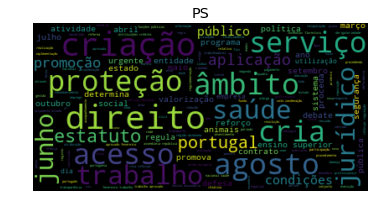

trabalho 169
nacional 149
agosto 105
saúde 96
jurídico 84
criação 80
setembro 74
ensino 71
junho 69
pública 68


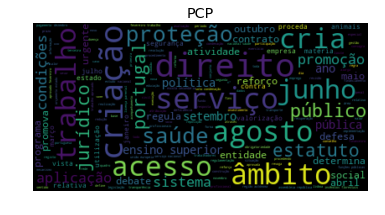

trabalho 171
nacional 150
agosto 107
saúde 99
jurídico 83
criação 78
ensino 71
pública 69
junho 69
setembro 67


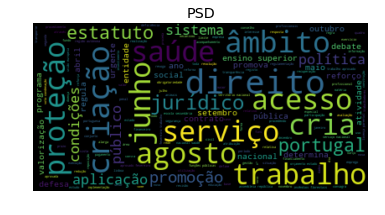

trabalho 168
nacional 149
agosto 107
saúde 99
jurídico 86
criação 81
ensino 71
pública 68
junho 68
setembro 67


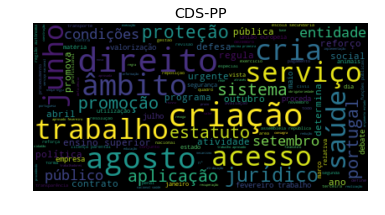

trabalho 176
nacional 148
agosto 104
saúde 98
jurídico 84
criação 80
primeira 73
junho 70
ensino 70
pública 69


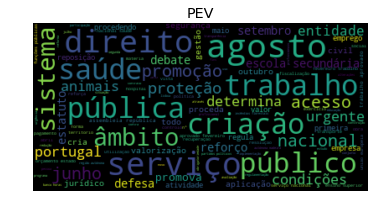

trabalho 122
nacional 81
saúde 58
agosto 50
pública 45
escola 42
público 41
procedendo 40
animais 40
serviço 39


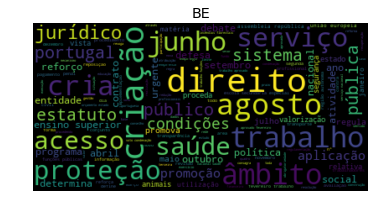

trabalho 174
nacional 141
agosto 107
saúde 91
jurídico 84
criação 78
ensino 71
pública 70
junho 69
setembro 67


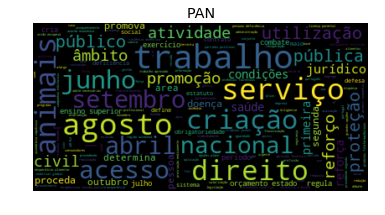

trabalho 73
nacional 41
animais 37
agosto 32
criação 27
combate 27
acesso 26
junho 26
jurídico 26
utilização 25


In [23]:
for party in party_names:
    word_cloud(party)
    most_common_words(party, 10)

## 4.Deputados

### 4.1.Deputados que mais falam

Nest instancia, vamos analisar os deputados que mais intervêem em cada ano:

In [24]:
def top_speakers(year, number_of_speakers):
    print ('-' * 15, 'TOP SPEAKERS FOR YEAR {}'.format(year), '-' * 15)
    print (assembleia[(assembleia.intervention_type==u'Intervenção') 
                   & (assembleia['date'] > '{}-01-01'.format(year))
                   & (assembleia['date'] < '{}-01-01'.format(year + 1)) ].speaker.value_counts(normalize=False)[0:number_of_speakers])
    
for year in range(2015, 2018):
    top_speakers(year, 15)
    print ('')

--------------- TOP SPEAKERS FOR YEAR 2015 ---------------
HELOÍSA APOLÓNIA           17
ANDRÉ SILVA                10
RITA RATO                   8
JOÃO OLIVEIRA               8
JOANA MORTÁGUA              7
ANTÓNIO CARLOS MONTEIRO     6
PAULA SANTOS                6
LUÍS MONTENEGRO             5
ANTÓNIO FILIPE              5
CATARINA MARTINS            4
ISABEL GALRIÇA NETO         4
JOSÉ LUÍS FERREIRA          4
CECÍLIA MEIRELES            4
TELMO CORREIA               4
JOÃO GALAMBA                4
Name: speaker, dtype: int64

--------------- TOP SPEAKERS FOR YEAR 2016 ---------------
JOSÉ LUÍS FERREIRA       70
HELOÍSA APOLÓNIA         64
ANDRÉ SILVA              59
ANTÓNIO FILIPE           34
JOÃO RAMOS               33
CARLA CRUZ               28
MIGUEL TIAGO             26
PEDRO FILIPE SOARES      26
NUNO MAGALHÃES           25
DIANA FERREIRA           25
CECÍLIA MEIRELES         25
JOANA MORTÁGUA           25
JOÃO PINHO DE ALMEIDA    24
JOSÉ MOURA SOEIRO        24
RITA RATO  

### 4.2.Deputados que menos falam

E os que menos falam.

In [25]:
def top_speakers(year, number_of_speakers):
    print ('-' * 15, 'BOTTOM SPEAKERS FOR YEAR {}'.format(year), '-' * 15)
    print (assembleia[(assembleia.intervention_type==u'Intervenção') 
                   & (assembleia['date'] > '{}-01-01'.format(year))
                   & (assembleia['date'] < '{}-01-01'.format(year + 1)) ].speaker.value_counts(normalize=False)[-number_of_speakers:])
    
for year in range(2015, 2018):
    top_speakers(year, 20)
    print ('')

--------------- BOTTOM SPEAKERS FOR YEAR 2015 ---------------
ANDREIA NETO                  1
ROSA MARIA BASTOS ALBERNAZ    1
CATARINA MARCELINO            1
PAULO SÁ                      1
MARCO ANTÓNIO COSTA           1
CLARA MARQUES MENDES          1
NUNO SERRA                    1
RUBINA BERARDO                1
JOÃO PAULO REBELO             1
SUSANA LAMAS                  1
ANTÓNIO VENTURA               1
JORGE PAULO OLIVEIRA          1
EURICO BRILHANTE DIAS         1
JOAQUIM BARRETO               1
INÊS DOMINGOS                 1
FERNANDO JESUS                1
FERNANDO ANASTÁCIO            1
PAULA TEIXEIRA DA CRUZ        1
PAULO NEVES                   1
ANA SOFIA BETTENCOURT         1
Name: speaker, dtype: int64

--------------- BOTTOM SPEAKERS FOR YEAR 2016 ---------------
JOSÉ PEDRO AGUIAR BRANCO        1
BACELAR DE VASCONCELOS          1
INÊS LAMEGO                     1
LUÍS PEDRO PIMENTEL             1
JOSÉ DE MATOS CORREIA           1
JOÃO REBELO                     1
LUÍ

### 4.3.Wordcloud de deputados

In [26]:
def tokenized_text(speaker):
    """
    Returns the token list of all of the speaker interventions
    """

    # vamos buscar dados a dataframe
    interventions_of_speaker = assembleia.loc[(assembleia.speaker == speaker) &
                   (assembleia.intervention_type == u'Intervenção')].drop_duplicates(subset='summary_text', keep="last") # tabela com intervenções
    interventions_of_speaker = interventions_of_speaker.drop_duplicates() # limpar duplicate rows se existirem ainda

    # agregamos dados da dataframe
    speaker_text = '' # string vazia onde vamos por todos os textos sumarios 
    for index, row in interventions_of_speaker.iterrows():
        speaker_text = speaker_text + ' ' + row['summary_text'] # adiciona todas as linhas de intervenções
        
    # limpamos dados da dataframe
    speaker_text_lower = speaker_text.lower() # lower case everything
    speaker_text_tokens = nltk.word_tokenize(speaker_text_lower) # tokenize text
    speaker_text_tokens = [token.lower() for token in speaker_text_tokens if token.isalpha()] # remove punctuation and numbers
    speaker_text_tokens = [token for token in speaker_text_tokens 
                         if token not in nltk.corpus.stopwords.words('portuguese')] # remove stopwords
    black_words = ['governo', 'recomenda', 'lei', u'código', u'alteração',
                   'regime', 'medidas', 'sobre', 'altera', 'aprova', u'adoção',
                   'estabelece', 'procede', 'apoio', 'processo', 'solicitam']
    speaker_text_tokens = [token for token in speaker_text_tokens if token not in black_words] # remove black listed words
    
    return speaker_text_tokens

In [27]:
def person_word_cloud(tokens):
    """
    Returns a wordcloud from tokens
    """
    clean_text = " ".join(tokens)
    wordcloud = WordCloud(max_font_size=40).generate(clean_text)
    plt.figure()
    plt.title(speaker)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

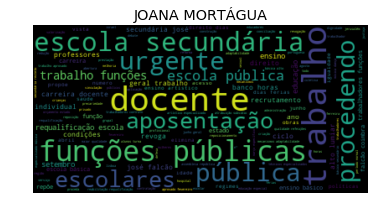

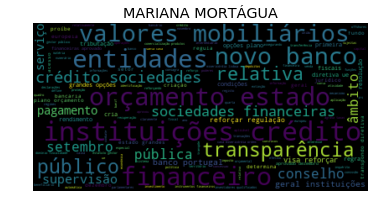

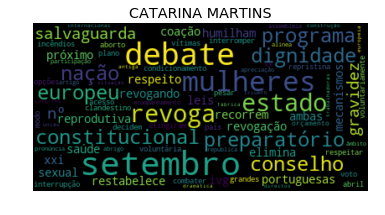

In [28]:
speakers = [u'JOANA MORTÁGUA', u'MARIANA MORTÁGUA', 'CATARINA MARTINS']

for speaker in speakers:
    person_word_cloud(tokenized_text(speaker))